In [1]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [19]:
data_path = "../data/BOLT Data Set.xlsx"
og_df = pd.read_excel(data_path)

In [23]:
df = og_df.copy()

In [24]:
from datetime import datetime
def fix_time(time_str):
    og_time = time_str
    if time_str == "na:n:":
        return np.nan
    try:
        time_str = time_str.replace(":", "").replace(".0", "")
        time_str = '{:0>{}}'.format(time_str, 6)
        time_fixed = datetime.strptime(time_str, '%H%M%S').strftime('%H:%M:%S')
        return time_fixed
    except Exception as e:
        print(e)
        print(og_time)
        return np.nan


In [25]:
# Pre-Processing Columns
df['Transaction Time'] = df['Transaction Time'].apply(fix_time)
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date'].astype(str) + ' ' + df['Transaction Time'])
df['Fraud Indicator'] = df['Fraud Indicator (Yes/No)'].map({'Yes': 1, 'No': 0})

In [26]:
df.head()

,Card Identifier,Transaction Date,Transaction Time,Risk Assessment,Payment Method,Transaction Value,Merchant Location,Card Present Status,Chip Usage,Cross-border Transaction (Yes/No),Acquiring Institution ID,Merchant Identifier,Merchant Category Code (MCC),Fraud Indicator (Yes/No),Transaction Date and Time,Fraud Indicator
0,card 1,2023-05-11,16:22:14,362.0,Paypass - Contactless,13.98,USA,CP,Yes,No,acquirer 1,merchant 1,5812.0,No,2023-05-11 16:22:14,0
1,card 2,2023-06-05,15:16:35,602.0,Online,24.64,USA,CNP,No,No,acquirer 2,merchant 2,4121.0,No,2023-06-05 15:16:35,0
2,card 3,2023-06-05,11:57:40,482.0,Unknown,15.00,USA,CNP,No,No,acquirer 3,merchant 3,7211.0,No,2023-06-05 11:57:40,0
3,card 4,2023-07-20,18:26:30,947.0,Online,30.56,USA,CNP,No,No,acquirer 1,merchant 4,5814.0,No,2023-07-20 18:26:30,0
4,card 5,2023-03-03,19:03:11,1382.0,Magnetic Stripe,50.85,USA,CP,No,No,acquirer 4,merchant 1,5812.0,No,2023-03-03 19:03:11,0


In [61]:
df.describe()

,Transaction Date,Risk Assessment,Transaction Value,Merchant Category Code (MCC),Transaction Date and Time,Fraud Indicator
count,100000,99028.000000,100000.000000,99997.000000,97963,100000.00000
mean,2023-06-28 20:34:09.120000256,843.157905,71.130702,5807.915887,2023-06-29 00:51:40.721476352,0.00265
min,2023-01-01 00:00:00,2.000000,0.000000,742.000000,2023-01-01 00:26:59,0.00000
25%,2023-03-30 00:00:00,352.000000,6.840000,5411.000000,2023-03-30 17:21:35,0.00000
50%,2023-06-27 00:00:00,592.000000,19.230000,5812.000000,2023-06-27 12:14:39,0.00000
75%,2023-09-27 00:00:00,1052.000000,50.000000,5942.000000,2023-09-26 19:01:10.500000,0.00000
max,2023-12-31 00:00:00,4932.000000,15000.000000,9999.000000,2023-12-31 23:55:55,1.00000
std,NaN,747.146439,296.637398,1061.918829,NaN,0.05141


## Build Graph

In [85]:
from sklearn.utils import resample

df_majority = df[df['Fraud Indicator'] == 0]
df_minority = df[df['Fraud Indicator'] == 1]

df_maj_downsampled = resample(df_majority, n_samples=2000, random_state=42)
df_downsampled = pd.concat([df_minority, df_maj_downsampled])

In [86]:
df_downsampled['Fraud Indicator'].value_counts()

Fraud Indicator
0    2000
1     265
Name: count, dtype: int64

In [87]:
print( df_downsampled["Card Identifier"].nunique(), df_downsampled["Merchant Identifier"].nunique() )

1452 497


In [137]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id, x in enumerate(set(df["Card Identifier"].values.tolist() + df["Merchant Identifier"].values.tolist()))}
    
    df["from"] = df["Card Identifier"].apply(lambda x: mapping[x])
    df["to"] = df["Merchant Identifier"].apply(lambda x: mapping[x])
    
    df = df[["from", "to", "Transaction Value", "Fraud Indicator"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum}).reset_index()
    
    df["Fraud Indicator"] = df["Fraud Indicator"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Fraud Indicator"] \
                               for idx, x in \
                               df[["from", "to", "Fraud Indicator"]].iterrows()},
                           "label")
    
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Transaction Value"] \
                               for idx, x in \
                               df[["from", "to", "Transaction Value"]].iterrows()},
                           "weight")
    return G, mapping

In [138]:
# Directed Graph
G_bu, mapping = build_graph_bipartite(df_downsampled, nx.Graph(name="Bipartite Undirect"))
# Directed Graph
G_bd, _ = build_graph_bipartite(df, nx.DiGraph(name="Bipartite Direct"))

C:\Users\simon\AppData\Local\Temp\ipykernel_22332\4270206850.py:8: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df[["from", "to", "Transaction Value", "Fraud Indicator"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum}).reset_index()
C:\Users\simon\AppData\Local\Temp\ipykernel_22332\4270206850.py:8: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df[["from", "to", "Transaction Value", "Fraud Indicator"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum}).reset_index()


In [139]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu) == bipartite.is_bipartite(G_bd) == True


True

In [140]:
print(G_bu)

Graph with 1949 nodes and 2107 edges


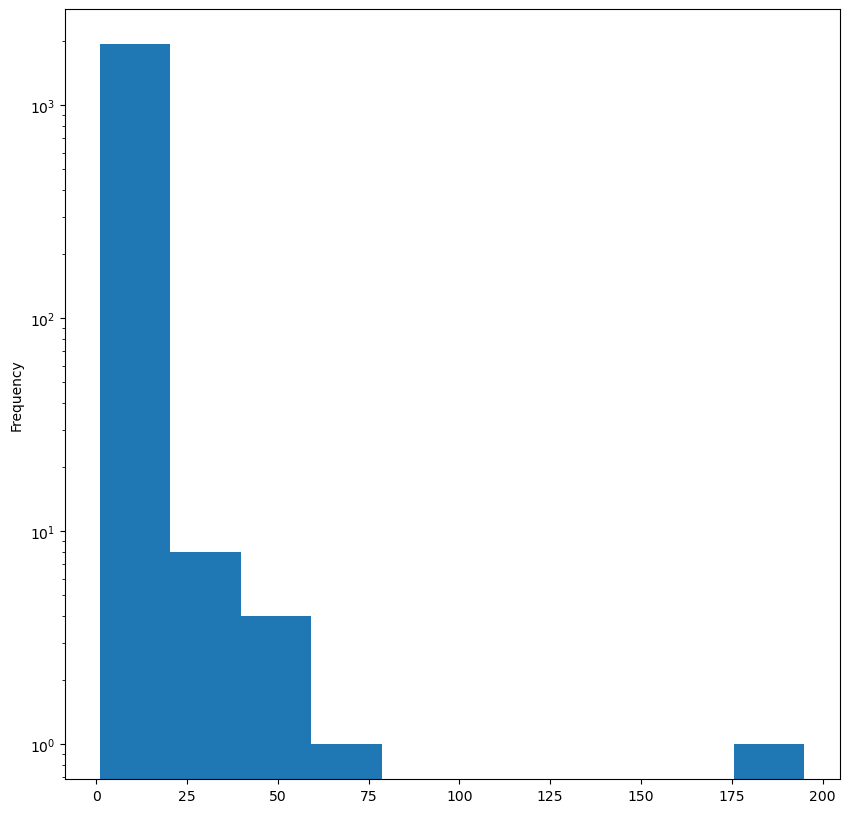

In [141]:
plt.figure(figsize=(10,10))
degrees = pd.Series(
    {
        k:v for k,v in nx.degree(G_bu)
    }
)
degrees.plot(kind="hist")
plt.yscale("log")

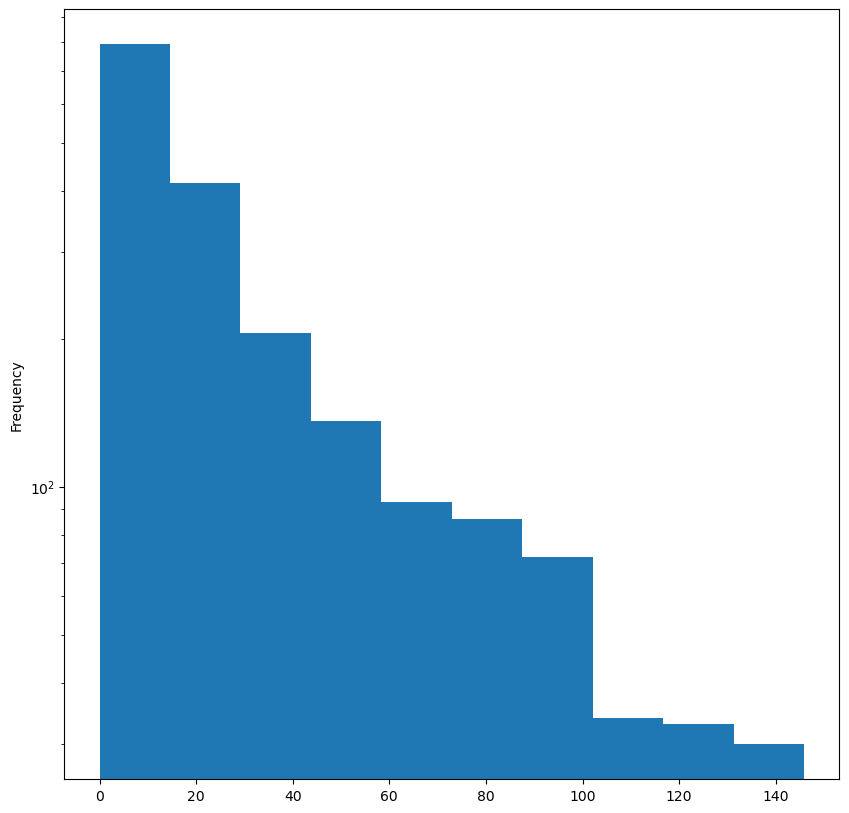

In [142]:
for G in [G_bu]:
    allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    np.quantile(allEdgesWeights.values,[0.10, 0.50, 0.70, 0.90])
    quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.90])
    allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)
                                    if d[2]["weight"] < quant_dist[-1]})
    plt.figure(figsize=(10,10))
    allEdgesWeightsFiltered.plot(kind="hist")
    plt.yscale("log")

In [144]:
import community

parts = community.best_partition(G_bu, random_state=42, weight="weight")
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False).head(20)

8     203
1     128
4      81
2      68
40     67
20     60
46     60
3      60
33     55
10     46
12     39
25     39
9      33
18     32
34     31
29     31
52     28
51     24
24     19
76     19
Name: count, dtype: int64

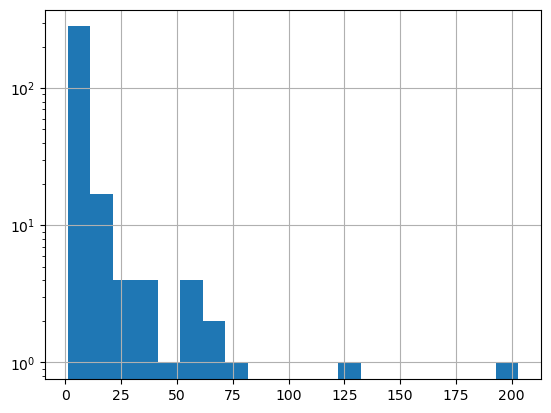

In [145]:
communities.value_counts().hist(bins=20);
plt.yscale("log")

In [146]:
communities

0        0
1539     0
1944     0
2        1
659      1
        ..
293     34
1943    53
1803    53
1947    33
1948    40
Length: 1949, dtype: int64

In [147]:
# Ratio of fradulent / benign nodes in communities
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G_bu, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.set_option('display.max_rows', 500)
pd.Series(d).sort_values(ascending=False).head(60)
# pd.set_option('display.max_rows', 100)

296    100.000000
22     100.000000
308    100.000000
170    100.000000
300    100.000000
298    100.000000
161    100.000000
68     100.000000
286    100.000000
77     100.000000
277    100.000000
224    100.000000
92     100.000000
268    100.000000
264    100.000000
136    100.000000
239    100.000000
315    100.000000
246    100.000000
185    100.000000
72      90.909091
129     80.000000
7       75.000000
45      66.666667
110     50.000000
9       43.750000
119     42.857143
49      41.666667
17      37.500000
29      30.000000
18      25.806452
140     25.000000
33      22.222222
52      18.518519
69      16.666667
14      16.666667
12      15.384615
28      14.285714
106     14.285714
3       13.559322
34      13.333333
46      13.333333
67      12.500000
15      12.500000
2       11.594203
78      11.111111
4       11.111111
25      10.526316
20       8.474576
27       8.333333
8        7.729469
157      6.250000
47       5.882353
24       5.555556
10       4.444444
40       3

In [148]:
graphs[9]

In [124]:
nx.get_edge_attributes(graphs[9], 'label').values()

dict_values([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

In [158]:
reversed_mapping = {v: k for k, v in mapping.items()}

In [129]:
nx.nodes(graphs[9])

NodeView((385, 647, 10, 653, 1039, 1302, 1945, 921, 1439, 289, 1314, 166, 295, 1319, 1837, 559, 1843, 1848, 828, 1731, 457, 720, 979, 986, 1884, 1377, 233, 1131, 1519, 1520, 879, 1777, 1019))

In [161]:
node_colors = []
for node in nx.nodes(graphs[9]):
    id = reversed_mapping[node]
    if id.startswith("card"):
        node_colors.append("b")
    else:
        node_colors.append("y")
node_colors

['y',
 'b',
 'b',
 'y',
 'b',
 'b',
 'y',
 'b',
 'b',
 'b',
 'b',
 'y',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'y',
 'y',
 'b',
 'b',
 'b']

In [192]:
def plot_community(gId):
    plt.figure(figsize=(16,16))
    spring_pos = nx.spring_layout(graphs[gId])
    plt.axis("off")
    edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
    node_colors = []
    labels = {}
    for node in nx.nodes(graphs[gId]):
        id = reversed_mapping[node]
        labels[node] = id
        if id.startswith("card"):
            node_colors.append("b")
        else:
            node_colors.append("c")
    nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=node_colors, edge_color=edge_colors, labels=labels, with_labels=True, node_size=70)

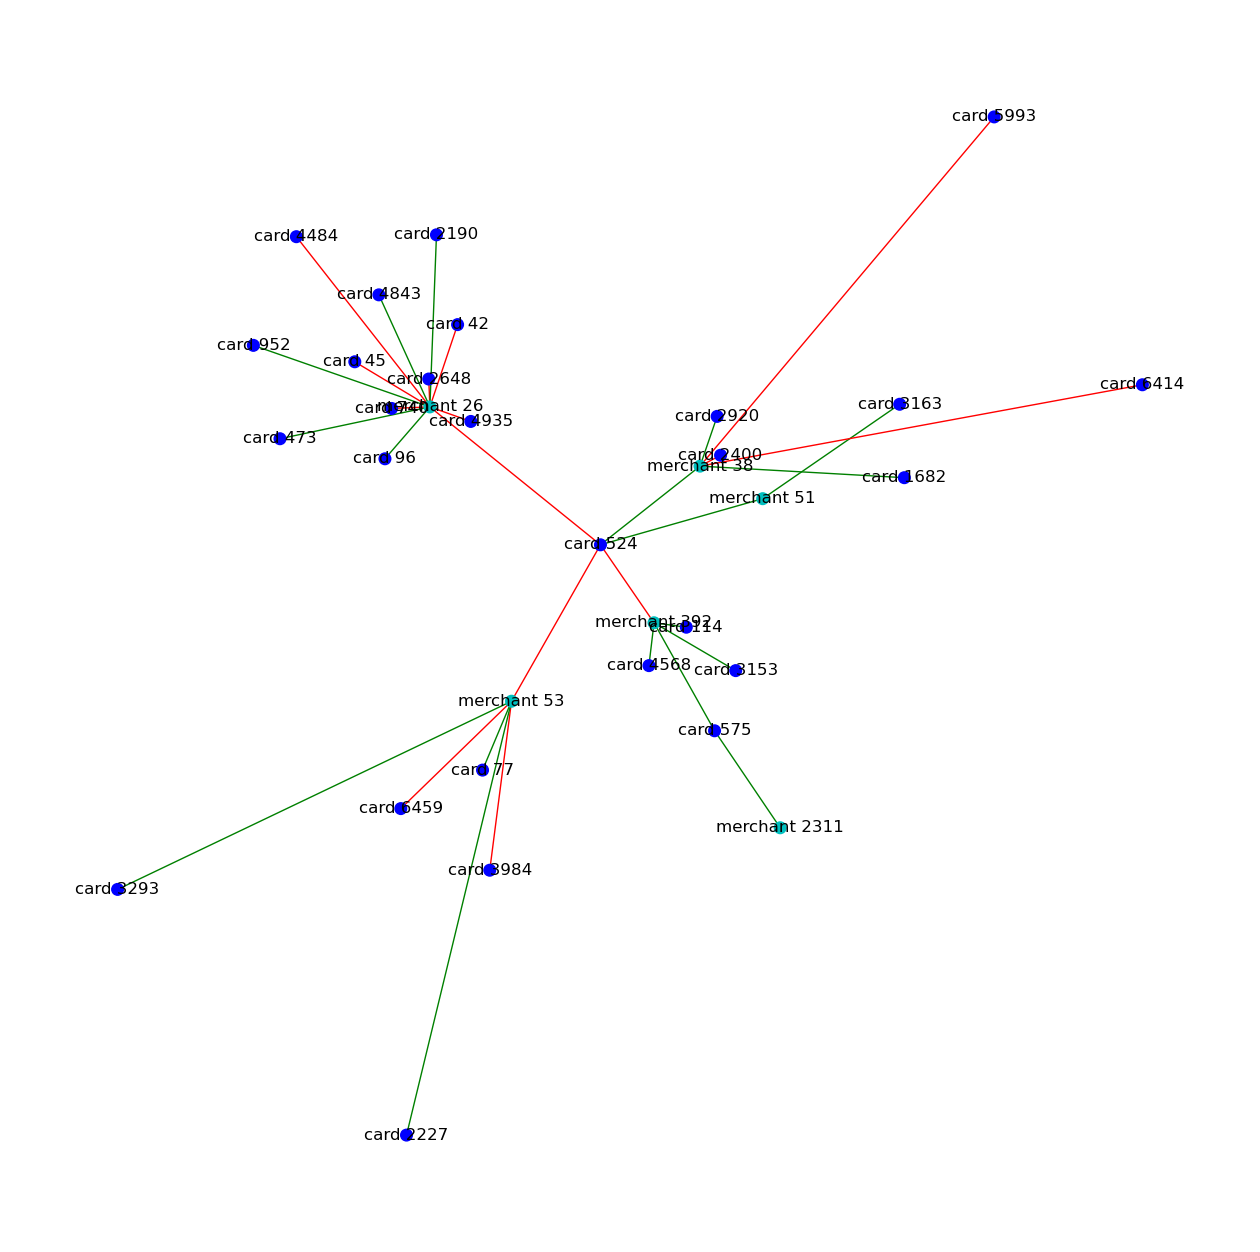

In [193]:
plot_community(9)